<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                   TAs: Sheng-Yu, Jinkun, Rawal, Arka, Rohan

In [1]:
import nbimporter
import numpy as np
import skimage
import multiprocess
import threading
import queue
import os,time
import math
from ipynb.fs.defs.p1 import get_visual_words
from ipynb.fs.defs.p2 import get_image_feature, distance_to_set

ModuleNotFoundError: No module named 'ipynb'

In [2]:
from function2 import get_visual_words
import matplotlib.pyplot as plt

In [3]:
from function2 import get_image_feature, distance_to_set, get_visual_words, extract_filter_responses, get_feature_from_wordmap, get_feature_from_wordmap_SPM

## For Autograding P3, ensure uploading `conf_matrix.npy`.

### Quantitative Evaluation

#### Calculating confusion matrix
Qualitative evaluation is all well and good (and very important for diagnosing performance gains and losses), but we want some hard numbers.

Load the corresponding test images and their labels, and compute the predicted labels of each, i.e., compute its distance to every image in training set and return the label with least distance difference as the predicted label. To quantify the accuracy, you will compute a confusion matrix $C$: given a classification problem, the entry $C(i,j)$ of a confusion matrix counts the number of instances of class $i$ that were predicted as class $j$. When things are going well, the elements on the diagonal of $C$ are large, and the off-diagonal elements are small. Since there are 8 classes, $C$ will be $8 \times 8$. The accuracy, or percent of correctly classified images, is given by the trace of $C$ divided by the sum of $C$.

#### Q3.1.1 (10 Points -> 5 Autograder + 5 WriteUp)
Implement the function
```
            def evaluate_recognition_system():
```
that tests the system and outputs the confusion matrix.

Report the confusion matrix and accuracy for your results in your write-up. This does not have to be formatted prettily: if you are using LaTeX, you can simply copy/paste it into a $verbatim$ environment. Additionally, do not worry if your accuracy is low: with 8 classes, chance is $12.5\%$. To give you a more sensible number, a reference implementation _with_ spatial pyramid matching gives an overall accuracy of around $50\%$.

Trained features shape:  (1000, 4200)
Test data shape:  (160,)


100%|██████████| 160/160 [00:00<?, ?it/s]


Predicted labels shape:  (160,)


100%|██████████| 160/160 [00:00<?, ?it/s]

Accuracy: 0.6
accuracy = 0.6
conf_mat = array([[14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 14.,  0.,  0.,  0.,  1.,  2.,  1.],
       [ 0.,  0., 15.,  3.,  4.,  1.,  0.,  2.],
       [ 1.,  3.,  2., 10.,  0.,  3.,  1.,  6.],
       [ 2.,  0.,  0.,  0., 10.,  1.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  7., 12.,  2.,  0.],
       [ 0.,  3.,  1.,  1.,  3.,  2., 11.,  0.],
       [ 0.,  1.,  1.,  4.,  2.,  0.,  1., 10.]])


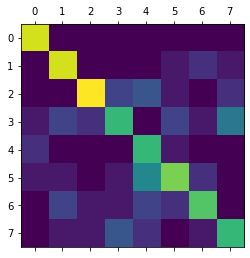

In [5]:
from tqdm import tqdm
def helper_func(args):
    file_path, dictionary, layer_num, K, trained_features, train_labels = args
    # YOUR CODE HERE
    _, feature = get_image_feature(file_path, dictionary, layer_num, K)
    distances = distance_to_set(feature, trained_features)
    nearest_image_idx = np.argmax(distances)
    pred_label = train_labels[nearest_image_idx]    
    
    return [file_path, pred_label, nearest_image_idx]


def evaluate_recognition_system(num_workers=2):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS
    (1) You may wish to use multiprocessing to improve speed (NO Extra Points)
    (2) You may create helper function (in the same cell) to enable multiprocessing
    (3) Think Nearest Neighbor -> assign label using element closest in train set
    '''
    from function2 import helper_func
    test_data = np.load("./data/test_data.npz")
    trained_system = np.load("trained_system.npz")
    
    image_names = test_data['files']
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']
    
    dictionary = trained_system['dictionary']
    SPM_layer_num = trained_system['SPM_layer_num']
    SPM_layer_num = int(SPM_layer_num)
    K = dictionary.shape[0]

    print("Trained features shape: ", trained_features.shape)
    print("Test data shape: ", image_names.shape)

    
    # ----- TODO -----
    '''
    HINTS:
    1.> Think almost exactly similar to Q1.2.2
    2.> Create a list of arguments and use multiprocessing library
    3.> We can define a helper function which can take in the arguments (file_path, dictionary, SPM_layer_num,
        trained_features,...) as input and return (file_path, label, nearest neighbor index)
    4.> We can use python dictionary and file_path to have the output in correct order
    '''
    # YOUR CODE HERE
   
    list_of_args = []
    for i in tqdm(range(len(image_names))):
        full_image_name = './data/' + image_names[i]
        list_of_args.append([full_image_name, dictionary, SPM_layer_num, K, trained_features, train_labels])
    
    import skimage, multiprocessing
    with multiprocessing.Pool(num_workers) as p:
        out = p.map(helper_func, list_of_args)
            
    '''
    HINTS:
    1.> Can use the file_name (path) to place the labels back in original order of input to multiprocessing
    '''    
    # YOUR CODE HERE
    
    ordered_labels, indices = [label for path, label, _ in out], [index for _, _, index in out]
    ordered_labels = np.array(ordered_labels, dtype=int)
    print("Predicted labels shape: ", ordered_labels.shape)
    
    '''
    HINT:
    1.> Compute the confusion matrix (8x8)
    2.> Remember to save and upload the confusion matrix
    '''
    # YOUR CODE HERE
    conf_matrix = np.zeros((8, 8))
    for i in tqdm(range(ordered_labels.shape[0])):        
        conf_matrix[test_labels[i], ordered_labels[i]] += 1
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)    
    np.save("./conf_matrix.npy",conf_matrix)
    return conf_matrix, accuracy

## NOTE: comment out the lines below before submitting to gradescope
    #conf_matrix, accuracy = evaluate_recognition_system()
## We expect the accuracy to be greater than 0.45

conf_mat, accuracy = evaluate_recognition_system()
print("Accuracy:", accuracy)
print(f'{accuracy = }')
print(f'{conf_mat = }')



<font color="blue">**Submit the Confusion Matrix and the Accuracy Value in the WriteUp**</font>

#### Q3.1.2 (5 points WriteUp):
<font color="blue"> As there are some classes/samples that are more difficult to classify than the rest using the bags-of-words approach, they are more easily classified incorrectly into other categories. **List some of these classes/samples and discuss why they are more difficult in your write-up.** </font>

### Q3.1.3 [Extra Credit](10 points) Manually Graded:

Now that you have seen how well your recognition system can perform on a set of real images, you can experiment with different ways of improving this baseline system. Here are a few suggestions:

* Hyperparameter Tuning: here is a list of hypterparameters in the system that you can tune to get better performance for your system:
        
        * `filter_scales`: a list of filter scales used in extracting filter response;
        * `K`: the number of visual words and also the size of the dictionary;
        * `alpha`: the number of sampled pixels in each image when creating the dictionary;
        * `L`: the number of spatial pyramid layers used in feature extraction.
        
* Image manipulation: Try using image augmentation techniques such as (1) random-crop, (2) flipping, (3) add noise, (4) jittering, etc. to obtain more training data for your system. You can also try resizing the images, subtracting the mean color, etc. 

* Better classifier: in part 2 we used the nearest neighbor classifier to classify test images. However, with our extracted SPM features from training images, we can use other classifiers such as multi-class logistic regression, multi-class support vector machine, etc. to gain better performance. For this, you can use implementation of these algorithms from `scipy`.


Tune the system you build to reach around 65\% accuracy on the provided test set (``data/test_data.npz``). <font color="blue">**In your writeup, document what you did to achieve such performance: (1) what you did, (2) what you expected would happen, and (3) what actually happened.** Also, include a file called ``custom.py/ipynb`` for running your code. </font>

### Q3.1.4 [Extra Credit] (25 points): Manually Graded
**GIST feature descriptor:** As introduced during the lecture, GIST feature descriptor is a feature extractor based on Gabor Filters. When we apply it to images, we have to implement the 2D Gabor Filters as described below

<img align="center" src="figures/gist.png" width="800">

In this part, please try to derive GIST features of images and study its effect to the performance of our built recognition system. The extra credits come from two parts:

* (10 points) Implement GIST feature extractor and visualize the features from the provided image `sun_aydaknxraiwghvmi.jpg`.
* (10 points) Try to incorporate the GIST features into the recognition system. You can feel free to tune the parameters and choose your classifier. Explain your observations and reasoning.

<font color="blue">**In your writeup (5 points): How does GIST descriptor affect the performance? Better or worse? Explain your reasoning?**
    

In [ ]:
def compute_GIST():
    # YOUR CODE HERE
    raise NotImplementedError()

def evaluate_recognition_System_GIST():
    # YOUR CODE HERE
    raise NotImplementedError()